In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('eda_data.csv')


In [6]:

# choose relevant columns
df.columns

df_model = df[['avg_salary','Rating','Size','Type of ownership','Industry','Sector','Revenue','num_comp','hourly','employer_provided',
             'job_state','same_state','age','python_yn','spark','aws','excel','job_simp','seniority','desc_len']]


In [9]:
# get dummy data
df_dum = pd.get_dummies(df_model)

In [10]:

# train test split
from sklearn.model_selection import train_test_split

X = df_dum.drop('avg_salary', axis =1)
y = df_dum.avg_salary.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:

# multiple linear regression
import statsmodels.api as sm

X_sm = X = sm.add_constant(X)
model = sm.OLS(y, X.astype(float))
print(model.fit().summary())

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score

lm = LinearRegression()
lm.fit(X_train, y_train)

np.mean(cross_val_score(lm,X_train,y_train, scoring = 'neg_mean_absolute_error', cv= 3))


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     10.21
Date:                Sat, 23 Sep 2023   Prob (F-statistic):           1.47e-94
Time:                        19:13:15   Log-Likelihood:                -3311.6
No. Observations:                 742   AIC:                             6909.
Df Residuals:                     599   BIC:                             7568.
Df Model:                         142                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

-117903799.50512792

,alpha,error
12,0.13,-19.257798


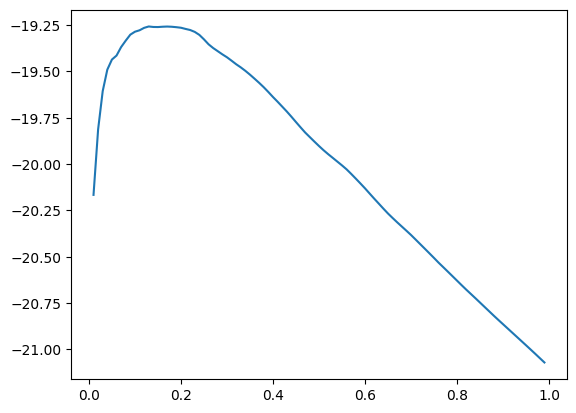

In [12]:
# lasso regression
lm_l = Lasso(alpha=.13)
lm_l.fit(X_train,y_train)
np.mean(cross_val_score(lm_l,X_train,y_train, scoring = 'neg_mean_absolute_error', cv= 3))

alpha = []
error = []

for i in range(1,100):
    alpha.append(i/100)
    lml = Lasso(alpha=(i/100))
    error.append(np.mean(cross_val_score(lml,X_train,y_train, scoring = 'neg_mean_absolute_error', cv= 3)))

plt.plot(alpha,error)

err = tuple(zip(alpha,error))
df_err = pd.DataFrame(err, columns = ['alpha','error'])
df_err[df_err.error == max(df_err.error)]



In [13]:
# random forest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

np.mean(cross_val_score(rf,X_train,y_train,scoring = 'neg_mean_absolute_error', cv= 3))


-15.045417628057223

In [15]:
# tune models GridsearchCV
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
parameters = {
    'n_estimators': range(10, 300, 10),
    'criterion': ['friedman_mse', 'squared_error', 'poisson', 'absolute_error'],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create the GridSearchCV object
gs = GridSearchCV(rf, parameters, scoring='neg_mean_absolute_error', cv=3, n_jobs=-1)


# Fit the model
gs.fit(X_train, y_train)

# Get the best score and estimator
best_score = gs.best_score_
best_estimator = gs.best_estimator_

print(f"Best Score: {best_score}")
print(f"Best Estimator: {best_estimator}")



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Best Score: -14.810491035567177
Best Estimator: RandomForestRegressor(criterion='poisson', max_features='auto')


In [20]:

# test ensembles
tpred_lm = lm.predict(X_test)
tpred_lml = lm_l.predict(X_test)
tpred_rf = gs.best_estimator_.predict(X_test)
print(tpred_lm)
print(tpred_lml)
print(tpred_rf)


[113.83767174  48.5        123.299078   110.33649422 154.8312258
 139.94767658 136.02688526  30.7105232   45.51476823  83.66055708
 153.57780709  77.00857442 117.9377128  132.50220425  42.99968586
 145.07629487  68.87772943  64.7193175  127.13511197  87.26532161
 101.58503326 109.91824074 149.94088379 112.21599153 148.29374144
 101.0379714   75.7493255  135.94456298  93.93222823 113.17255645
  69.65194076  52.11471652 143.41273052 113.47367932 105.60805619
  82.41659586  72.53626012 112.57795931  62.98138705 117.43787785
 169.676872   111.07730974  77.45665231 104.83492661 151.10276451
  90.75808219 153.21283211 120.91089634 146.66124101  86.18864242
 116.58432961 115.85285567 103.45524375 106.14354176  92.1173666
 131.71166095  77.45665231  89.80521275 169.32826007 137.90812398
 126.19412669 112.15380227 131.71904127 144.35898996 101.51135841
 107.5        106.13531738 137.20480945 115.1585599   89.30659987
 151.10276451 137.20480945  54.70527185 126.24333297  26.5
 101.51135841  71.0

In [19]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test,tpred_lm)
mean_absolute_error(y_test,tpred_lml)
mean_absolute_error(y_test,tpred_rf)

print(mean_absolute_error(y_test,(tpred_lm+tpred_rf)/2))


14.263377982803679


In [18]:

import pickle
pickl = {'model': gs.best_estimator_}
pickle.dump( pickl, open( 'model_file' + ".p", "wb" ) )

file_name = "model_file.p"
with open(file_name, 'rb') as pickled:
    data = pickle.load(pickled)
    model = data['model']

model.predict(np.array(list(X_test.iloc[1,:])).reshape(1,-1))[0]

list(X_test.iloc[1,:])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


[3.6,
 0.0,
 0.0,
 0.0,
 1.0,
 34.0,
 0.0,
 0.0,
 0.0,
 1.0,
 4608.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
